<a href="https://colab.research.google.com/github/rahultheogre/GAN_Googdfellow_Pytorch/blob/main/GAN_Goodfellow_MNIST_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic GAN on MNIST

- The following is a step by step introductory GAN implemention in PyTorch as first proposed by Goodfellow in his seminal paper that introduced GANs to the world.
- One can find the link of the paper here: https://arxiv.org/pdf/1406.2661.pdf
- The images, code-snippets etc are from that paper.

## Basic Libraries

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

import torchvision.datasets as datasets #to fetch MNIST

from torch.utils.data import DataLoader 
import torchvision.transforms as transform #for image data transformations

## Discriminator Class definition

In [13]:
class Discriminator(nn.Module): #inherit from nn.Module
  def __init__(self,img_dim): #initialization of Discrimnator
    # for MNIST img_dim would be 784 (a flattened version of the 28*28*1 image)
    super().__init__() 
    self.disc = nn.Sequential( #defining disc object of class Discriminator
    # there are 2 FC layers in this Discriminator:                           
        nn.Linear(img_dim, 128), #take img_dim to 128 nodes #linear aggregator
        nn.LeakyReLU(0.1), #LeakyRelU preferred for GANs #activation function
        nn.Linear(128,1), #FC layer before the output layer #from 128 nodes to 1 node
        nn.Sigmoid(), #output layer
    )

  def forward(self, x):
    return self.disc(x) #in the Discriminator class we are running the disc method
    # which is basically nn.Sequential of various operators

## Generator class definition

In [14]:
class Generator(nn.Module):
  def __init__(self, z_dim, img_dim): #the generator class takes in 
  # z_dim and img_dim as parameters
  # z_dim is the dimension of the latent noise
    super().__init__()
    self.gen = nn.Sequential( 
    # There are two FC layers in this simple Generator
        nn.Linear(z_dim, 256), #dimension of the hidden noise
        # 256 is the number of nodes in first later
        nn.LeakyReLU(0.1),
        nn.Linear(256,img_dim), #The generator is transforming
        # z_dim to img_dim
        nn.Tanh(), # we are using Tanh so that output 
        # of the pixel values may be between -1 and 1
        # we are going to normalize the input from MNIST to  -1 and 1
        # so the output should be the same.
        ) 
    
  def forward(self, x):
    return self.gen(x)

## Hyperparameters

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 3e-4 #usually good with Adam in the case of GANs
z_dim = 256 #dimension of the noise being fed into the GAN
#GANS are incredibly sensitive to hyperparameters
image_dim = 28*28*1 #MNIST
batch_size = 32 #standard batch size
num_epochs = 50

## Initializing the Discriminator and Generator

In [16]:
disc = Discriminator(image_dim).to(device) #creating an object of class
#Discriminator and taking it to device

In [17]:
# similarly creating an object of Generator class ad saving it to device. 
gen = Generator(z_dim, image_dim).to(device)

In [18]:
# setting some fixed noise because we want to see how it changes across the epochs
# we are going to use tensorboard that will give us very good visualization
# fixed_noise = torch.randn((batch_size, z_dim)).to(device) # random  noise is a matrix 
# of size z_dim and there are batch_size of them

## Transformation of data



- Transforms are common image transformations available in the torchvision.transforms module. 
- They can be chained together using Compose
- We also normalize the data by subtracting a mean of 0.5
- 

In [19]:
transformed = transform.Compose(
    [transform.ToTensor(), 
     transform.Normalize((0.5,), (0.5,))]
)

# 'transformed' is the new image object that we end up with after a series of transformations

## Preprocessing of Dataset

In [20]:

#datasets.MNIST calls the MNIST dataset we are after
dataset = datasets.MNIST(root='dataset/', #the folder where the dataset gets saved temporarily
                         transform=transformed, #we are transforming the image data 
                         download=True) # we download it if it has already not been downloaded
# dataset is the final transformed object that has been downloaded and saved in the local folder called dataset

## Creating a DataLoader object

- The idea is to use batch-normalization for faster processing
- DataLoader helps in various functionalities like creating batches of the data we have

In [21]:
# loader is an object of the DataLoader which gives us batches of dataset fed into it. 
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Defining Optimizer

In [22]:
# we are using Adam for both
opt_disc = optim.Adam(disc.parameters(),lr=lr) #optimizer for Discriminator
opt_gen = optim.Adam(gen.parameters(),lr=lr)

## Defining Loss Function

In [23]:
#Like Goodfellow we will use BCE loss
criterion = nn.BCELoss()

# Training the Network

### VALUE FUNCTION

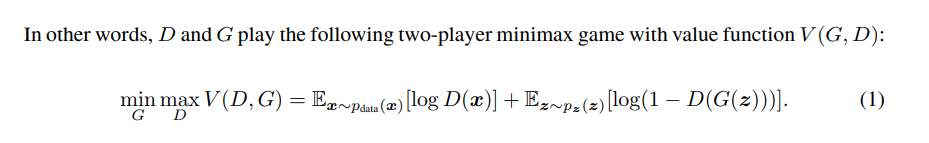

- After a series of arguments, which I am not writing here, we come to the conclusion that we have to deal with the various parts of the above equation in the above ways keeping in mind that the Discriminator has two possible classes: Fake (0) or Real(1).

Training Discriminator : 
- max log(D(real)) + log(1-D(G(z))) 

Training Generator:
- max log(D(G(z)))

In [25]:
# running through loop in a loop with inner loop taking care of the batches, 
# and outer loop taking care of the epochs


for epoch in range(num_epochs): #looping through the epochs. in each epoch we do:
  for batch_idx, (real, _) in enumerate(loader): # we are taking in loader object 
  # loader is an object of the DataLoader which gives us shuffled batches of dataset fed into it. 
                                            #and selecting batches from it at random
                                            # for each batch index, we are running the following
    # in the tuple above, we are naming the images as real
    # the class is not given any value, because GANs are unsupervised and that is the
    # task of the generator to decide which is real and which is not. 
    real = real.view(-1,784).to(device) # reshaping the images # basically flattenning it.
    # in case of CNN we will not go for flattening
    batch_size = real.shape[0] #checking the batch size #first dimension of the shape of vector

    # TRAINING DISCRIMINATOR : max(log(D(real)) + log(1-D(D(z))))
    # --> min(-(log(D(real)) + log(1-D(D(z)))))

    # generating fake images with z = noise 
    # G(z) = gen(noise)
    noise = torch.randn(batch_size, z_dim).to(device) # randomly generated matrix
    fake = gen(noise) #creating fake images out of noise with Generator G

    # putting fake images through Discriminator
    # D(G(z))
    disc_fake =  disc(fake).view(-1) 

    # lossD_fake = log(1-D(G(z))) 
    lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
    # we are sending in zeros by torch.zeros_like

    # REAL DATA (x)
    # What the Discriminator outputs on the real image
    # disc_real = D(real)
    disc_real =  disc(real).view(-1) #view(-1) implies it is flattened

    # lossD_real =  log(D(real))
    lossD_real = criterion(disc_real, torch.ones_like(disc_real))
    # torch.ones_like(disc_real)= we are sending in ones. Because in this case the
    # data is real. So we are interested in output of the discriminator function as 1. 

    # Final loss function wrt Discriminator
    lossD = (lossD_real + lossD_fake) / 2

    disc.zero_grad()
    lossD.backward(retain_graph = True) # wish to utilize the fake (G(z)) weight values
    opt_disc.step()

    # TRAINING GENERATOR: min  log(1-D(G(z)))
    # the above expression leads to saturated gradients.
    # So, we maximize log(D(g(z)))
    # We will use the recalculations done previously

    output = disc(fake).view(-1)
    lossG = criterion(output, torch.ones_like(output))

  
    gen.zero_grad()
    lossG.backward()
    opt_gen.step()

    # .view() Tensor.view(*shape) → Tensor
    # Returns a new tensor with the same data as the self tensor but of a different shape.

# TENSORBOARD

It won't run on Google Collab

In [26]:
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard

In [27]:
fixed_noise = torch.randn((batch_size, z_dim)).to(device)

In [28]:
if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
                data = real.reshape(-1, 1, 28, 28)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)

                writer_fake.add_image(
                    "Mnist Fake Images", img_grid_fake, global_step=step
                )
                writer_real.add_image(
                    "Mnist Real Images", img_grid_real, global_step=step
                )
                step += 1